In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

from matplotlib import pyplot as plt
import decoupler as dc

In [2]:
from sklearn.neighbors import BallTree

In [3]:
import geopandas as gpd

In [4]:
import muon as mu
import liana as li

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'aggregate_fun' is not a valid key!


In [5]:
# slide names and x, y offsets
slides = {'A1':[3.5, 18],
          'B1':[3, 10.5],
          'C1':[1, 13.5],
          }

In [6]:
## load slide
slide = "B1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085
slide_path = f"data/sma/{exp}/{exp}_{slide}/output_data"
rna_path = slide_path + f"/{exp}_{slide}_RNA/outs/"

In [7]:
rna = sq.read.visium(rna_path, counts_file="filtered_feature_bc_matrix.h5")
rna.obs[['x', 'y']] = rna.obsm['spatial']

msi_raw = pd.read_csv(slide_path + f"/{exp}_{slide}_MSI/{exp}_{slide}.Visium.FMP.220826_smamsi.csv")


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [8]:
# set x and y columns as index, concat with _ as separator
msi_raw.index = msi_raw[['x', 'y']].astype(str).agg('_'.join, axis=1)

In [9]:
# Only for mouse
lesion = pd.read_csv(rna_path + "/lesion.csv").set_index("Barcode")
region = pd.read_csv(rna_path +  "/region.csv").set_index("Barcode")
rna.obs = rna.obs.join(lesion)
rna.obs = rna.obs.join(region)

MSI

In [10]:
msi = msi_raw.copy().drop(['x', 'y'], axis=1)
msi = sc.AnnData(X=msi.values,
                 obs=pd.DataFrame(index=msi.index),
                 var=pd.DataFrame(index=msi.columns))

In [11]:
# copy raw intensities
msi.layers['raw'] = msi.X.copy()

# normalize and cluster (as they do)
sc.pp.normalize_total(msi, target_sum=1e4)
sc.pp.log1p(msi)
sc.pp.scale(msi)
sc.pp.pca(msi)
sc.pp.neighbors(msi, n_neighbors=10, n_pcs=20)
sc.tl.leiden(msi, resolution=0.00001)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts


In [12]:
# get positions; NOTE: x and y are mirrored in the msi data
positions = msi_raw[['y', 'x']].values.copy()

# estimate scaling factor
sfactor = rna.uns['spatial'][f"{exp}_{slide}"]['scalefactors']['fiducial_diameter_fullres']
sfactor

608.9063

In [13]:
# inverse y
positions[:, 0] = (positions[:, 0].max() - positions[:, 0])
# offset
x_offset = slides[slide][0]
y_offset = slides[slide][1]

positions[:, 0] = positions[:, 0] + x_offset
positions[:, 1] = positions[:, 1] + y_offset

msi.obs[['array_row', 'array_col']] = positions

# scale
positions = positions * sfactor * 0.95

In [14]:
msi.uns = rna.uns.copy()

In [15]:
msi.obsm['spatial'] = positions
msi.obs[['x', 'y']] = positions

In [16]:
# remove cells that are not in the tissue
msi = msi[msi.obs['leiden'] != '1', :]

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning


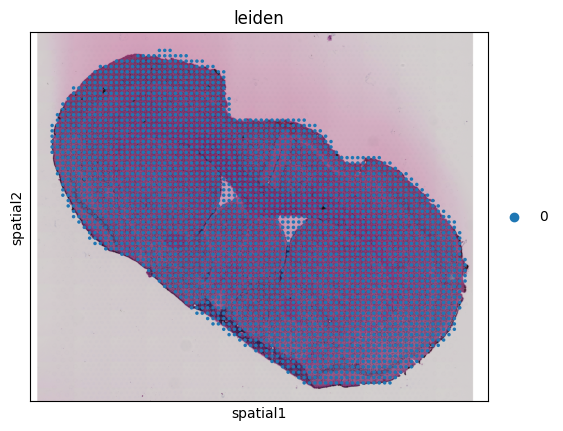

In [17]:
sc.pl.spatial(msi, color="leiden")

In [18]:
# msi.obs.index = msi.obsm['spatial']

In [19]:
mdata = mu.MuData({'rna':rna, 'msi':msi})

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


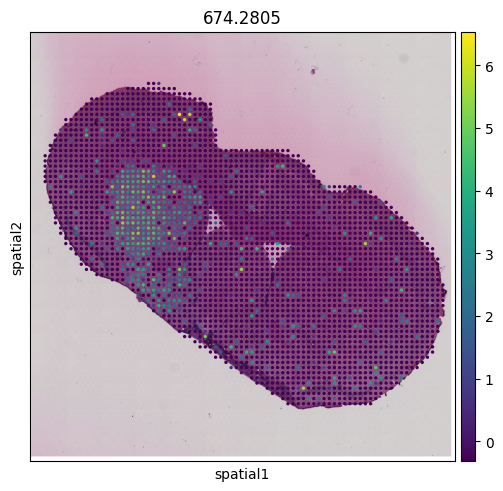

In [20]:
sq.pl.spatial_scatter(msi, color=['674.2805']) # plot dopamine

In [21]:
# swap back to raw intensities
mdata.mod['msi'].X = mdata.mod['msi'].layers['raw'].copy()

## QC

In [22]:
rna.var_names_make_unique()
msi.var_names_make_unique()

### Process RNA

In [23]:
sc.pp.filter_cells(mdata.mod['rna'], min_genes=200)
sc.pp.filter_cells(mdata.mod['rna'], min_counts=100)
sc.pp.filter_genes(mdata.mod['rna'], min_cells=3)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


### Process metabolites

In [24]:
# change type to float
msi.var['mz'] = msi.var.index.astype(float)
# round to 2 decimals
msi.var['mz'] = [round(x, 2) for x in msi.var['mz']]

In [25]:
msi.var['max_intensity'] = msi.X.sum(axis=0)

In [26]:
msi.var['mz_raw'] = msi.var.index.astype(str)

In [27]:
molecule_weights = {
    'GABA': 371.18,
    'GABA-H2O': 353.16,
    'Taurine': 393.13,
    'Serotonin': 444.21,
    'Histidine': 423.18,
    '3-MT': 435.21,
    'Dopamine (single)': 421.19,
    'Dopamine (double)': 674.28,
    'DOPAC': 689.24,
    'NE (Norepinephrine)': 690.28,
    'Tocopherol': 698.49
}

In [28]:
msi.var['annotated'] = msi.var['mz'].map({v: k for k, v in molecule_weights.items()})
msi.var['annotated'] = msi.var['annotated'].astype('category')
# if Name is NaN, then use mz_raw
msi.var['name'] = msi.var.apply(lambda x: x['mz_raw'] if pd.isnull(x['annotated']) else x['annotated'], axis=1)
msi.var['name'] = msi.var['name'].astype('str')

In [29]:
msi.var.set_index('name', inplace=True)

(array([  6.,  11.,  55., 275., 749., 836., 713., 278.,  67.,  15.]),
 array([1.13601113e+08, 1.31690926e+08, 1.49780739e+08, 1.67870552e+08,
        1.85960365e+08, 2.04050178e+08, 2.22139991e+08, 2.40229803e+08,
        2.58319616e+08, 2.76409429e+08, 2.94499242e+08]),
 <BarContainer object of 10 artists>)

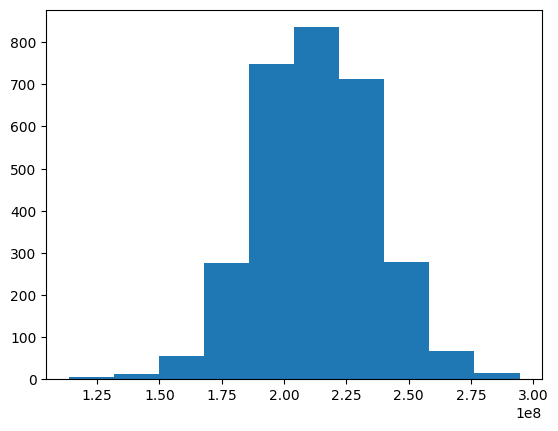

In [30]:
plt.hist(msi.X.sum(axis=1))

In [31]:
sc.pp.filter_cells(msi, min_counts=200)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


(array([  6.,  11.,  55., 275., 749., 836., 713., 278.,  67.,  15.]),
 array([1.13601113e+08, 1.31690926e+08, 1.49780739e+08, 1.67870552e+08,
        1.85960365e+08, 2.04050178e+08, 2.22139991e+08, 2.40229803e+08,
        2.58319616e+08, 2.76409429e+08, 2.94499242e+08]),
 <BarContainer object of 10 artists>)

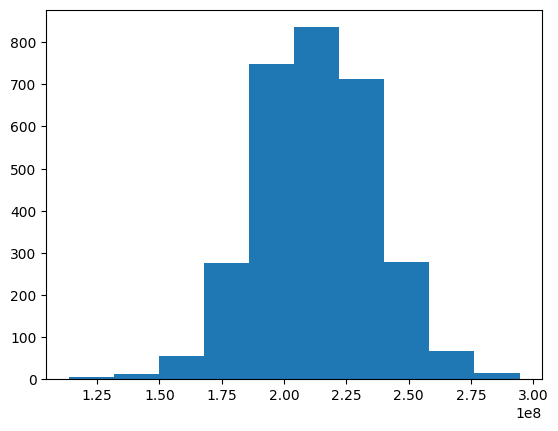

In [32]:
plt.hist(msi.X.sum(axis=1))

Normalize

In [33]:
mdata.mod['rna'].layers['counts'] = mdata.mod['rna'].X.copy()
sc.pp.normalize_total(mdata.mod['rna'], target_sum=1e4)
sc.pp.log1p(mdata.mod['rna'])

In [34]:
sc.pp.normalize_total(msi, target_sum=1)

In [35]:
mu.prot.pp.clr(msi)

Transfer annotations

In [36]:
# coordinates to points
rna_points = gpd.points_from_xy(rna.obs['x'], rna.obs['y'].values)
msi_points = gpd.points_from_xy(msi.obs['x'], msi.obs['y'].values)

In [37]:
original_gdf = gpd.GeoDataFrame(rna.obs[['region', 'lesion']], geometry=rna_points)
target_gdf = gpd.GeoDataFrame(msi.obs, geometry=msi_points)

In [38]:
rna.obs

,in_tissue,array_row,array_col,x,y,lesion,region,n_genes,n_counts
AAACAAGTATCTCCCA-1,1,50,102,34740,30651,lesioned,striatum,1562,3491.0
AAACAGCTTTCAGAAG-1,1,43,9,7784,27046,intact,not_striatum,626,1454.0
AAACATTTCCCGGATT-1,1,61,97,33275,36197,lesioned,striatum,2275,5784.0
AAACCCGAACGAAATC-1,1,45,115,38516,28139,lesioned,not_striatum,1193,2048.0
AAACCGGAAATGTTAA-1,1,54,124,41113,32686,lesioned,not_striatum,1127,1846.0
...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1,1,24,64,23757,17504,intact,not_striatum,2813,6917.0
TTGTTCTAGATACGCT-1,1,21,3,6074,15942,intact,not_striatum,2473,5693.0
TTGTTGTGTGTCAAGA-1,1,31,77,27517,21045,lesioned,not_striatum,2835,7132.0
TTGTTTCCATACAACT-1,1,45,27,13000,28069,intact,striatum,2751,8027.0


In [39]:
# target_gdf to orginary df, without geometry
target_df = pd.DataFrame(target_gdf.sjoin_nearest(original_gdf, how='left').drop(columns='geometry'))

In [40]:
# annotations to msi
mdata.mod['msi'].obs = target_df

... storing 'index_right' as categorical
... storing 'region' as categorical
... storing 'lesion' as categorical
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-package

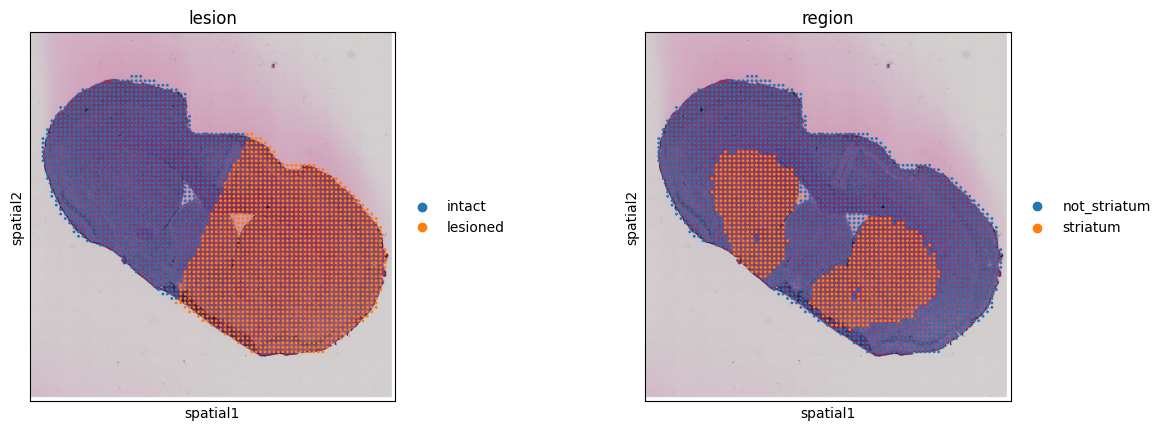

In [41]:
sq.pl.spatial_scatter(mdata.mod['msi'], color=['lesion', 'region'])

... storing 'lesion' as categorical
... storing 'region' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:747: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/home/dbdimitrov/anaconda3/e

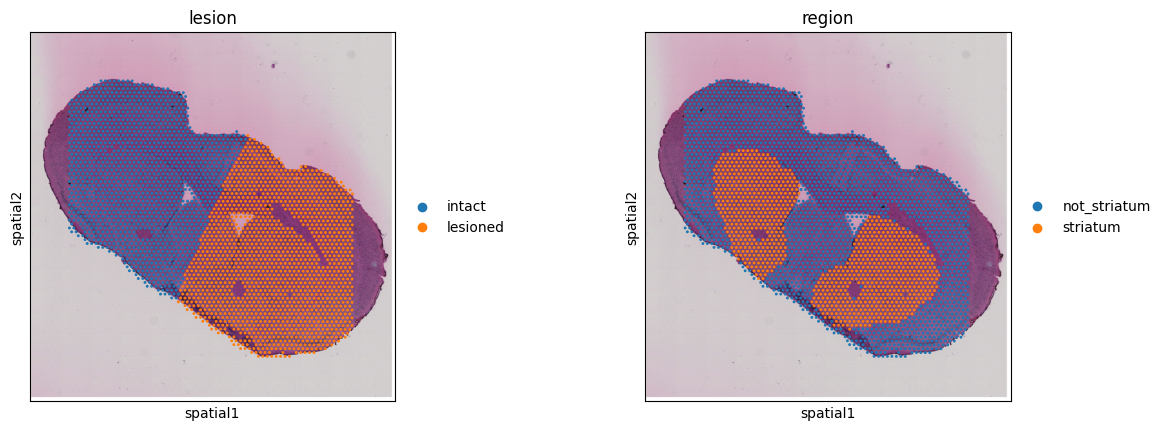

In [42]:
sq.pl.spatial_scatter(mdata.mod['rna'], color=['lesion', 'region'])

Write modalities as they are

In [43]:
mdata = mu.MuData(mdata.mod)
mdata.write_h5mu(os.path.join(slide_path, "sma.h5mu"))

### Match observations

MSI matched

In [44]:
rna_pos = rna.obsm['spatial'].copy()
msi_pos = msi.obsm['spatial'].copy()

In [45]:
# train kdtree on rna positions
tree = BallTree(rna_pos)

# find nearest neighbor for each msi spot
dists, neighbors = tree.query(msi_pos, k=1)
# flatten
dists, neighbors = dists.flatten(), neighbors.flatten()

# calculate proximities
proximity = 1 - (dists / np.max(dists))


(array([   5.,   21.,   21.,   13.,   40.,   39.,   34.,   39.,  103.,
        2690.]),
 array([0.        , 0.09943432, 0.19886864, 0.29830296, 0.39773728,
        0.4971716 , 0.59660593, 0.69604025, 0.79547457, 0.89490889,
        0.99434321]),
 <BarContainer object of 10 artists>)

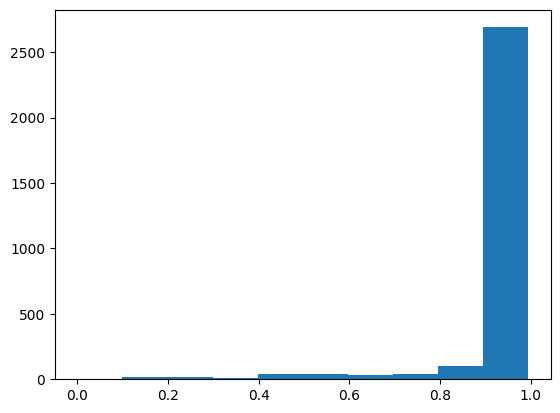

In [46]:
# get barcode of nearest neighbor
msi.obs['knn_barcode'] = rna.obs.iloc[neighbors, :].index
# get proximity of nearest neighbor
msi.obs['knn_proximity'] = proximity

# histrogram of distances
from matplotlib import pyplot as plt
plt.hist(proximity, bins=10)


... storing 'knn_barcode' as categorical


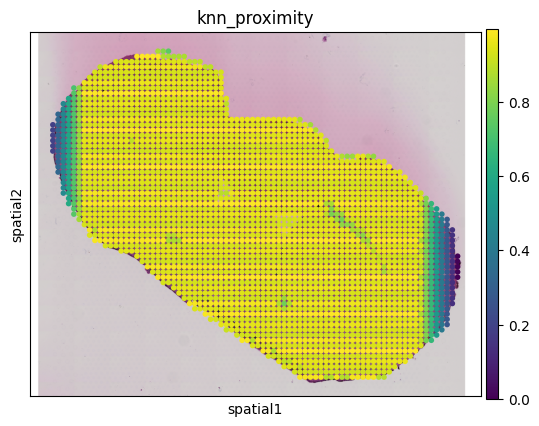

In [47]:
sc.pl.spatial(msi, color="knn_proximity", spot_size=sfactor)

In [48]:
# those with proximity of > 0.9 are considered to have a match
msk = msi.obs['knn_proximity'] > 0.9
matched = msi[msk, :].copy()
not_matched = msi[~msk, :].copy()

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [49]:
# those that barcodes are missing (not found as NN)
missing = rna[~rna.obs.index.isin(matched.obs['knn_barcode']), :].copy()
missing.X = np.zeros((missing.shape[0], missing.shape[1]))

In [50]:
matched = dc.get_pseudobulk(matched,
                            sample_col='knn_barcode',
                            groups_col=None, 
                            skip_checks=True, 
                            mode='mean', 
                            min_cells=0,
                            min_counts=0,
                            layer='raw'
                            )

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/decoupler/utils_anndata.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [51]:
matched.obs = matched.obs.join(rna.obs[['x', 'y']])

In [52]:
# merge anndata
msi_matched = sc.concat([matched, not_matched, missing], axis=0, label='modality', join='outer')
msi_matched.obsm['spatial'] = msi_matched.obs[['x', 'y']].values

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


RNA Matched

In [53]:
X = np.zeros([not_matched.shape[0], rna.shape[1]])

In [54]:
rna_missing = sc.AnnData(X=X, obs=not_matched.obs, var=rna.var)

In [55]:
rna_matched = sc.concat([rna, rna_missing], axis=0, label='modality', join='outer')
rna_matched.obsm['spatial'] = rna_matched.obs[['x', 'y']].values.copy()

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [58]:
### TODO: Standardize this function, and replace mean with weighted mean by proximity

Write matched coordinate systems

In [56]:
mdata_matched = mu.MuData({'rna': rna_matched, 'msi': msi_matched})

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [57]:
mdata_matched.write_h5mu(os.path.join(slide_path, "sma_matched.h5mu"))

... storing 'leiden' as categorical
... storing 'index_right' as categorical
... storing 'region' as categorical
... storing 'lesion' as categorical
... storing 'knn_barcode' as categorical
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
